# LSST Survey Cadence

Rubin Observatory has conducted extensive simulations, known as 'OpSims', of various iterations of the survey strategy with which LSST will start its first few years.  While the MAF metrics provide statistics such as the median intra-night gap as a histogram and function of HEALpixel this notebook compares the realized cadence for specific regions of the Galactic Plane and Bulge, and explores the distribution of the visits in different years of the survey.

In [22]:
import os
import json
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib as mpl
from astropy_healpix import HEALPix
from astropy import units as u
from astropy.coordinates import SkyCoord
import rubin_sim.maf as maf
import rubin_sim.phot_utils as phot_utils
from rubin_sim.data import get_data_dir
from rubin_sim.data import get_baseline
from rubin_sim.phot_utils import signaltonoise, PhotometricParameters
from pyLIMA.simulations import simulator
from pyLIMA import event, toolbox
from pyLIMA import telescopes
from pyLIMA.models import PSPL_model
from pyLIMA.outputs import pyLIMA_plots
import pyLIMA.fits.objective_functions
from pyLIMA.toolbox import fake_telescopes, plots
from mw_plot import MWSkyMap
%matplotlib inline

# Default HEALpixel resolution
NSIDE = 64

## Baseline simulations

To start with, we load the database of simulated observations from a realization of the LSST strategy. Simulations named 'baseline_' represent different iterations of the canonical survey design.  

The latest survey simulation results are available in the form of SQLite3 databases from [here](https://usdf-maf.slac.stanford.edu/?runId=2). 
The first step is to download the database corresponding to the opsim you wish to analyse, and declare the path to it on local disk below.

In [4]:
# UPDATE THIS
# Configure the path to the downloaded OpSim database to be analysed 
baseline_file = '/Users/rstreet/LSST/SCOC/baseline_v5.0.1_10yrs.db'

# Configure a path to save products from this notebook 
output_dir = '/Users/rstreet/Roman/RGES_PIT'

Next we load the results from the OpSim using functions from Rubin's own rubin_sim package.  The same package also contains the survey strategy metric code that we can used to assess the survey visits.  

In [5]:
# Load the opsim database
name = os.path.basename(baseline_file).replace('.db','')

outDir = 'temp'
resultsDb = maf.db.ResultsDb()

# This section selects which columns from the database will be loaded - in this case, the information on the 
# bandpass and MJD of each exposure, together with the 5sigma limiting magnitude.  
metric = maf.metrics.PassMetric(cols=['filter', 'observationStartMJD', 'fiveSigmaDepth'])
sql = ''

# Rubin filterset, and the single-visit limiting magnitude in each of those filters
filters = ['u', 'g', 'r', 'i', 'z', 'y']
mag_limit = {'u': 23.7, 'g': 24.97, 'r': 24.52, 'i': 24.13, 'z': 23.56, 'y': 22.55}

Since we are primarily interested in the number of visits a field receives we define the following function to extract the timestamps of simulated observations from the OpSim database.  

In [6]:
def get_slicer_timestamps(filters, dataSlice):
    """
    Function to extract the timestamps of observations for a specific target location from an opsim DB.
    """
    
    print('Total number of visits to this sky location over 10 yrs:')
    time_stamps = {}
    for f in filters:
        data = []
        # Observations in the current filter:
        fdx = np.where(dataSlice['filter'] == f)[0]
        print('  ' + f + ' n_visits= ' + str(len(fdx)))
        for i in fdx:
            jd = dataSlice['observationStartMJD'][i] + 2400000.5
            data.append(jd)
        time_stamps[f] = np.array(data)

    return time_stamps

## LSST cadence in the Plane and Bulge in different years

The Plane and Bulge receive different cadences in LSST as a matter of strategy, and this cadence can vary from year to year.  

To explore the number of visits that different pointings will receive, we take two nominal on sky locations: one in the bulge (which receives augmented cadence in some years) and one in the plane (which receives a more uniform cadence).  

In [11]:
# Take target positions in the Plane and Bulge
plane_target = SkyCoord(281.1125, -13.88194, frame='icrs', unit=(u.deg, u.deg))
bulge_target = SkyCoord('18:03:04', '-28:36:39', frame='icrs', unit=(u.hourangle, u.deg))

For reference, we can plot these locations on an all-sky map of the number of visits that Rubin will make to each HEALpixel. 

In [23]:
data_file = './rubin_nvisits_skymap.json'

with open(data_file, 'r') as f:
    survey_definition = json.load(f)

for key, value in survey_definition.items():
    if key != 'healpix_map':
        print(key + ' = ' + str(value))
    else:
        print(key + ' = Array of HEALpixels with ' + str(len(value)) + ' pixels')

nvisits_map = np.array(survey_definition['healpix_map'])

label = Rubin_baseline_v4.3.1_10yrs
nside = 64
healpix_resolution_deg = 0.00025566346464760684
n_healpix = 49152
healpix_map = Array of HEALpixels with 49152 pixels


In [40]:
# Normalizing the shading as a function of the number of visits.  
# The goal here is to show the number of visits in the Galactic plane region whereas in the default map the numbers of visits are 
# dominated by the DDFs.  
# Here we use the pixel set of the Galactic plane footprint to set the min-max values 
pixels = np.where(nvisits_map > 0)[0]
norm = mpl.colors.LogNorm(vmin=nvisits_map[pixels].min(), vmax=1200.0)

The locations of the choosen points are shown as yellow diamonds.

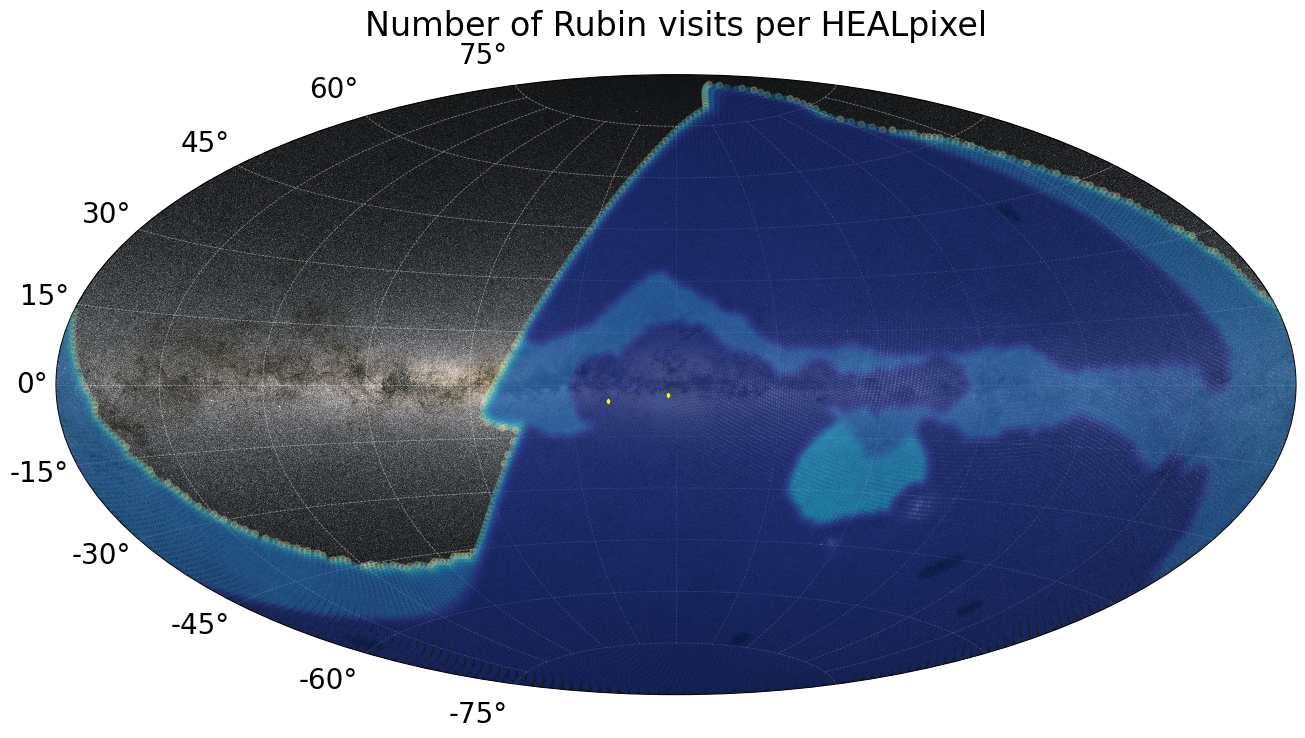

In [43]:
mw1 = MWSkyMap(projection='aitoff', grayscale=False, grid='galactic', background='optical', figsize=(16,10))
plt.rcParams.update({'font.size': 20})
proj = HEALPix(nside=NSIDE, order='ring', frame='icrs')
mw1.title = 'Number of Rubin visits per HEALpixel'
s = proj.healpix_to_skycoord(pixels)
pcm = mw1.scatter(
    s.ra.deg * u.deg, 
    s.dec.deg * u.deg, 
    c=nvisits_map[pixels], 
    cmap='YlGnBu', 
    norm=norm,
    s=20, 
    alpha=0.25
)
p1 = mw1.scatter(
    plane_target.ra.deg * u.deg,
    plane_target.dec.deg * u.deg,
    c='yellow',
    marker='d',
    s=5,
    alpha=1.0
)
p2 = mw1.scatter(
    bulge_target.ra.deg * u.deg,
    bulge_target.dec.deg * u.deg,
    marker='d',
    c='yellow',
    s=5,
    alpha=1.0
)

In order to calculate the numbers of visits that Rubin will make to these locations, we construct slicers that will extract the relevant entries from the OpSim database for us. 

In [44]:
# Create slicers for the survey HEALpixels corresponding to these targets
# Galactic Plane
plane_slicer = maf.slicers.UserPointsSlicer(ra=[plane_target.ra.deg], dec=[plane_target.dec.deg])
bundleList = [maf.MetricBundle(metric, plane_slicer, sql)]

# Run the chosen metrics for this slicer to get the opsim results for this target
bg = maf.MetricBundleGroup(
    bundleList, baseline_file, out_dir=outDir)
bg.run_all()
plane_dataSlice = bundleList[0].metric_values[0]

# Galactic Bulge
bulge_slicer = maf.slicers.UserPointsSlicer(ra=[bulge_target.ra.deg], dec=[bulge_target.dec.deg])
bundleList = [maf.MetricBundle(metric, bulge_slicer, sql)]

# Run the chosen metrics for this slicer to get the opsim results for this target
bg = maf.MetricBundleGroup(
    bundleList, baseline_file, out_dir=outDir)
bg.run_all()
bulge_dataSlice = bundleList[0].metric_values[0]

In [45]:
# Extract the timestamps of observations of these HEALpixels
print('Times of observations of the Plane field: ')
plane_time_stamps = get_slicer_timestamps(filters, plane_dataSlice)

print('Times of observations of the Bulge: ')
bulge_time_stamps = get_slicer_timestamps(filters, bulge_dataSlice)

Times of observations of the Plane field: 
Total number of visits to this sky location over 10 yrs:
  u n_visits= 30
  g n_visits= 159
  r n_visits= 179
  i n_visits= 160
  z n_visits= 156
  y n_visits= 43
Times of observations of the Bulge: 
Total number of visits to this sky location over 10 yrs:
  u n_visits= 26
  g n_visits= 296
  r n_visits= 330
  i n_visits= 392
  z n_visits= 312
  y n_visits= 46


Next we want to plot the number of visits to these sky locations that Rubin will make each year.  

The following cell works out the start and end dates of the annual seasons for Galactic plane and bulge observations. 

In [52]:
# Calculate the earliest timestamp in the survey, noting this may not occur on Jan 1
tmin = 2e7
for f, visits in bulge_time_stamps.items():
    tmin = min(tmin, visits.min())

# From tmin, set boundary dates for each year in JD
NYEARS = 10
lsst_seasons = [[tmin + nyr*365, tmin + (nyr+1)*364] for nyr in range(0, NYEARS, 1)]

And with this we can calculate the number of visits per year in different filters. 

In [47]:
def calc_annual_visits(time_stamps, lsst_seasons):
    """Function to calculate the number of visits to a given field per year per filter"""

    annual_visits = {}

    for f, visits in time_stamps.items():
        nvisits = []
        for yr in range(0, NYEARS, 1):
            tidx1 = np.where(visits >= lsst_seasons[yr][0])[0]
            tidx2 = np.where(visits <= lsst_seasons[yr][1])[0]
            tidx = list(set(tidx1).intersection(set(tidx2)))
            nvisits.append(len(visits[tidx]))
        annual_visits[f] = nvisits

    return annual_visits

In [48]:
plane_annual_visits = calc_annual_visits(plane_time_stamps, lsst_seasons)
bulge_annual_visits = calc_annual_visits(bulge_time_stamps, lsst_seasons)

Lastly, we can plot the results. 

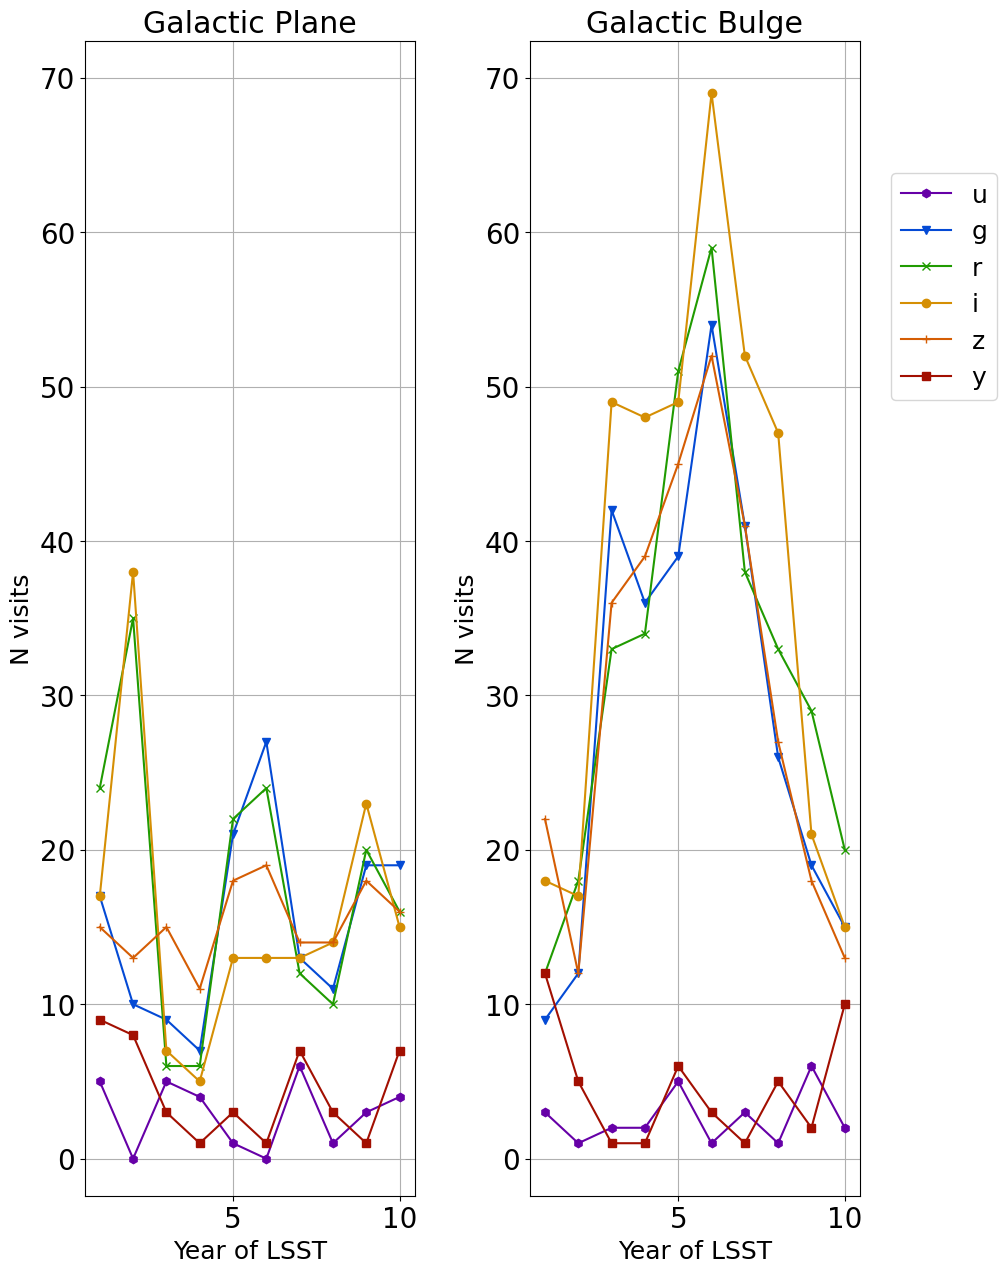

In [59]:
fig, axs = plt.subplots(1, 2, figsize=(10,15))
plt.subplots_adjust(wspace=0.35)

plot_colours = {'u': '#6600a7', 'g': '#044ad5', 'r': '#209b01', 'i': '#d58f04', 'z': '#d55d04', 'y': '#a20f01'}
plot_markers = {'u': 'h', 'g': 'v', 'r': 'x', 'i': 'o', 'z': '+', 'y': 's'} 

fontsize = 18
dt = 2460000.0

# SECOND ROW OF PLOTS
# Plot of number of visits per year for the Plane
survey_years = range(1, 11, 1)
for k,f in enumerate(filters):
    axs[0].plot(survey_years, plane_annual_visits[f], label=f, marker=plot_markers[f], color=plot_colours[f])

    axs[0].set_xlabel('Year of LSST', fontsize=fontsize)
    axs[0].set_ylabel('N visits', fontsize=fontsize)
axs[0].set_title('Galactic Plane', fontsize=fontsize*1.2)
axs[0].grid()
plane_yrange = axs[0].get_ylim()

# Plot of number of visits per year for the Bulge
survey_years = range(1, 11, 1)
for k,f in enumerate(filters):
    axs[1].plot(survey_years, bulge_annual_visits[f], marker=plot_markers[f], color=plot_colours[f])

    axs[1].set_xlabel('Year of LSST', fontsize=fontsize)
    axs[1].set_ylabel('N visits', fontsize=fontsize)
axs[1].set_title('Galactic Bulge', fontsize=fontsize*1.2)
bulge_yrange = axs[1].get_ylim()

ymin = min(plane_yrange[0], bulge_yrange[0])
ymax = max(plane_yrange[1], bulge_yrange[1])
axs[0].set_ylim([ymin, ymax])
axs[1].set_ylim([ymin, ymax])
axs[1].grid()

fig.legend(bbox_to_anchor=(1.05,0.8), ncol=1, fontsize=fontsize)


plt.savefig(os.path.join(output_dir, 'lsst_v4_nvisits_per_year.png'), bbox_inches='tight')

Sometimes it is helpful to have the same figure in a horizonal format. 

/var/folders/1d/5hlyfsgd0kl_nd815xmp9cv00000gn/T/ipykernel_70775/1965835590.py:40: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[1].set_xticklabels(xticklabels, fontsize=fontsize)


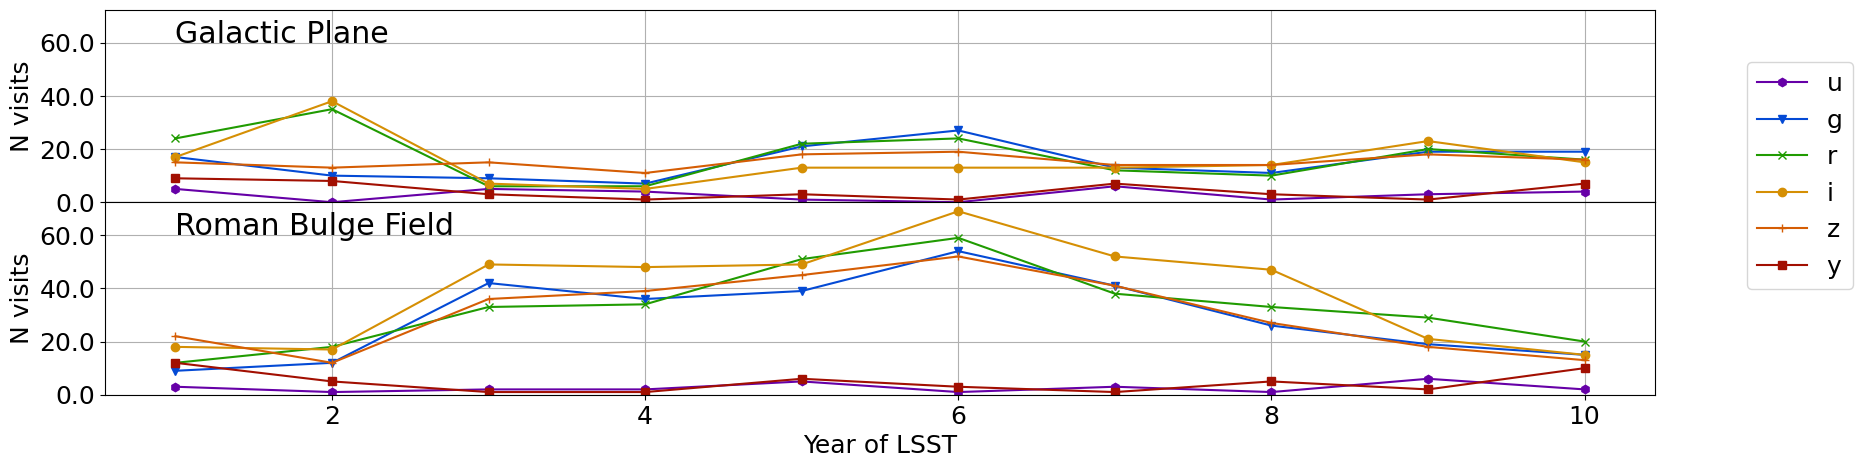

In [60]:
fig, axs = plt.subplots(2, 1, figsize=(20,5))
fig.subplots_adjust(hspace=0)

plot_colours = {'u': '#6600a7', 'g': '#044ad5', 'r': '#209b01', 'i': '#d58f04', 'z': '#d55d04', 'y': '#a20f01'}
plot_markers = {'u': 'h', 'g': 'v', 'r': 'x', 'i': 'o', 'z': '+', 'y': 's'} 

fontsize = 18
dt = 2460000.0

# Plot of number of visits per year for the Plane
survey_years = range(1, 11, 1)
for k,f in enumerate(filters):
    axs[0].plot(survey_years, plane_annual_visits[f], label=f, marker=plot_markers[f], color=plot_colours[f])

    axs[0].set_xlabel('Year of LSST', fontsize=fontsize)
    axs[0].set_ylabel('N visits', fontsize=fontsize)
#axs[0].set_title('Galactic Plane', fontsize=fontsize*1.2)
axs[0].grid()
axs[0].text(1,60,'Galactic Plane', fontsize=fontsize*1.2)
plane_yrange = axs[0].get_ylim()

# Plot of number of visits per year for the Bulge
survey_years = range(1, 11, 1)
for k,f in enumerate(filters):
    axs[1].plot(survey_years, bulge_annual_visits[f], marker=plot_markers[f], color=plot_colours[f])

    axs[1].set_xlabel('Year of LSST', fontsize=fontsize)
    axs[1].set_ylabel('N visits', fontsize=fontsize)
#axs[1].set_title('Galactic Bulge', fontsize=fontsize*1.2)
axs[1].text(1,60,'Roman Bulge Field', fontsize=fontsize*1.2)
bulge_yrange = axs[1].get_ylim()

ymin = min(plane_yrange[0], bulge_yrange[0])
ymin = max(0.0, ymin)
ymax = max(plane_yrange[1], bulge_yrange[1])
axs[0].set_ylim([ymin, ymax])
axs[1].set_ylim([ymin, ymax])
axs[1].grid()
xticklabels = [str(int(x)) for x in axs[1].get_xticks()] # Get current x-tick labels
axs[1].set_xticklabels(xticklabels, fontsize=fontsize)

yticks = np.arange(ymin, ymax, 20.0)
yticklabels = [str(y) for y in yticks] # Get current y-tick labels for both plots
axs[0].set_yticks(yticks)
axs[0].set_yticklabels(yticklabels, fontsize=fontsize)
axs[1].set_yticks(yticks)
#yticklabels = [str(y) for y in yticks] 
axs[1].set_yticklabels(yticklabels, fontsize=fontsize)
    
fig.legend(bbox_to_anchor=(1.005,0.8), ncol=1, fontsize=fontsize)


plt.savefig(os.path.join(output_dir, 'lsst_v4_nvisits_per_year_horiz.png'), bbox_inches='tight')